# Finding Traveling Waves
2025-11-18

This notebook shows the procedure for finding a traveling wave solution to the Navier-Stokes.

The naming here -- TW1 -- is based off of this paper: https://arxiv.org/pdf/0808.3375

In [1]:
using LinearAlgebra, Polynomials, Plots
using Revise, DelimitedFiles, BenchmarkTools
using CloudAtlas, BifurcationKit

"""
    myreaddlm(filename, cc='%')

Read matrix or vector from a file, dropping comments marked with cc.
"""
function myreaddlm(filename; cc='%')
    X = readdlm(filename, comments=true, comment_char=cc)
    if size(X,2) == 1
        X = X[:,1]
    end
    X
end

sx, sy, sz, tx, tz = halfbox_symmetries()

pwd()

"/home/ebenq/Dev/julia/CloudAtlas.jl/notebooks"

## Finding a Traveling Wave Solution

In [2]:
α, γ = 1.0, 2.0                     # Fourier wavenumbers α, γ = 2π/Lx, 2π/Lz
J,K,L = 3,3,6                       # Bounds on Fourier modes (J,K) and wall-normal polynomials (L)
H = [(sx*sy)*(tx*tz)]               # Generators of the symmetric subspace of TW1
normalize = false                   # Normalize the basis set or not?

model = TWModel(α, γ, J, K, L, H, normalize=normalize)  # Construct ODE model by Galerkin projection 

@show m = length(model)             # dimension of ODE model

J,K,L,m == 3,3,6,320
(2J+1)(2K+1)(2L+1) + 1 == 638
Making matrices B, A1, A2, Cx, Cz...
Phase constraints: keep_cx = false, keep_cz = true
Making quadratic operator N...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 23

320

In [3]:
# Parameters
hookparams = SearchParams(ftol=1e-08, xtol=1e-12, Nnewton=30,Nhook=8,δ=0.01, verbosity=0)
R = 200
cx0 = 0.000 # values from paper
cz0 = 0.009
## Optional: using ChannelflowWrapper to generate the initial guess from a Channelflow flowfield file.
# using ChannelflowWrapper
# x0 = field2coeff(model.ijkl, "data/TW1-2pi1piRe200-40x49x40.nc", "data/xtw1projection-Re$(R)-$(J)-$(K)-$(L)-$(m)d.asc")
# otherwise, read data from existing file
x0 = myreaddlm("data/xtw1projection-Re$(R)-$(J)-$(K)-$(L)-$(m)d.asc")
ξ0 = [x0; cx0; cz0] # combine everything into initial guess

322-element Vector{Float64}:
  0.13770614376906037
 -0.05070295518650626
 -0.004766573561578302
  0.025459392029286602
  0.009760888122005665
 -0.00534155141382762
  0.0006962187435854188
 -0.3491835879446625
  0.00967367368144975
 -0.022056361052061654
  0.004953584400061765
 -0.021007208569812506
  0.010009673032123937
  ⋮
  0.00016124594849542607
  7.035841240057588e-5
  0.00033753533694147713
  0.0003415303880929331
 -0.0001888373915796577
 -0.0001209333598071869
 -0.00044406331535021417
 -5.134952359712653e-5
 -0.00017985397774068432
 -0.00026920534760265993
  0.0
  0.009

In [4]:
# Create closures for g and Dg that capture R
g_closure(ξ) = model.g(ξ, R)
Dg_closure(ξ) = model.Dg(ξ, R)
# Use hookstep to find a solution
ξ_final, converged = hookstepsolve(g_closure, Dg_closure, ξ0, hookparams)

([0.12063652028490851, -0.04540810184901231, 0.0014455977003249823, 0.018830387316686577, 0.007622334441065651, -0.003392950708822023, 0.0014063695690606638, -0.35288925917695946, -0.003563157944471801, -0.01255267118629714  …  0.00011719496010320537, 8.419088445364184e-5, -7.309859528964096e-5, -6.841133258657813e-5, -0.00021484185646612142, -1.581142702865369e-5, -9.29002684424107e-5, -0.00013515718081589815, 0.0, -0.016336694457957008], true)

In [5]:
x_sol = ξ_final[1:m]
cx_sol = ξ_final[m+1]
cz_sol = ξ_final[m+2]
println("Norm of solution: ", norm(x_sol))
println("Wave speed in x: ", cx_sol)
println("Wave speed in z: ", cz_sol)
println("Converged: ", converged)

Norm of solution: 0.4119327351843059
Wave speed in x: 0.0
Wave speed in z: -0.016336694457957008
Converged: true


## 2. Bifurcation Analysis

In [6]:
"""
Continue a z-traveling wave (cx=0) solution branch in Reynolds number.
"""
function tw_z_branch_continuation(model, ξ_0, Re0;
                                  Re_min=100.0, Re_max=500.0,
                                  max_steps=1000, tol=1e-10, dsmin=1e-7)
    m = model.m
    x0 = ξ_0[1:m]
    cx0 = ξ_0[m+1]
    cz0 = ξ_0[m+2]
    
    # Pack state as [x; cz]
    u0 = vcat(x0, cz0) # State vector is length n+1
    
    # Define the fixed phase condition vector
    Du0_z = model.Cz * x0
    
    # Define residual function
    function f_tw_z(u, p)
        (; Re) = p
        x  = u[1:m]
        cz = u[end] 

        # Standard residual
        res_flow = (cz .* (model.Cz * x)) .- (model.A1 * x) .- ((1/Re) .* (model.A2 * x)) .- model.N(x)
        
        # Compute phase condition
        res_phase = dot(x .- x0, Du0_z)
        
        # Return combined vector
        return [res_flow; res_phase]
    end

    # Set up bifurcation problem
    params = (Re = Re0, x0_param = x0, Du0_param = Du0_z)
    
    prob = BifurcationProblem(
        f_tw_z, u0, params, (@optic _.Re);
        record_from_solution = (u, p_val; k...) -> (R=p_val, x=u[1:m], cx=0.0, cz=u[m+1], pow=shear(u[1:m], model))
    )
    
    # Continuation options
    opts = ContinuationPar(
        p_max=Re_max,
        p_min=Re_min,
        detect_bifurcation = 0, # Skip expensive stability/eigenvalue checks for speed
        n_inversion=20,
        max_steps=max_steps,
        newton_options=NewtonPar(tol=tol, max_iterations=20),
        dsmin=dsmin
    )
    
    println("Starting Z-TW continuation from Re = $Re0...")
    branch = continuation(prob, PALC(), opts, bothside=true)
    println("Continuation complete. Found $(length(branch.branch)) points.")
    return branch
end


tw_z_branch_continuation

In [7]:
branch = tw_z_branch_continuation(model, ξ_final, 200.0)

Starting Z-TW continuation from Re = 200.0...
Continuation complete. Found 2002 points.


 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 2002
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter Re starts at 236.78586441849774, ends at 340.82497229022147
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at Re ≈ +236.92728577,                                                                     step =  -1
- #  2,     fold at Re ≈ +159.95950655 ∈ (+159.95950547, +159.95950547), |δp|=-1e+00, [    guess], δ = ( 0,  0), step = 576
- #  3,     fold at Re ≈ +191.86405344 ∈ (+191.86405379, +191.86405379), |δp|=-1e+00, [    guess], δ = ( 0,  0), step = 847
- #  4,     fold at Re ≈ +188.96240665 ∈ (+188.96240557, +188.96240557), |δp|=-1e+00, [    guess], δ = ( 0,  0), step = 909
- #  5, endpoint at Re ≈ +340.96639365,                                                                     step = 2002


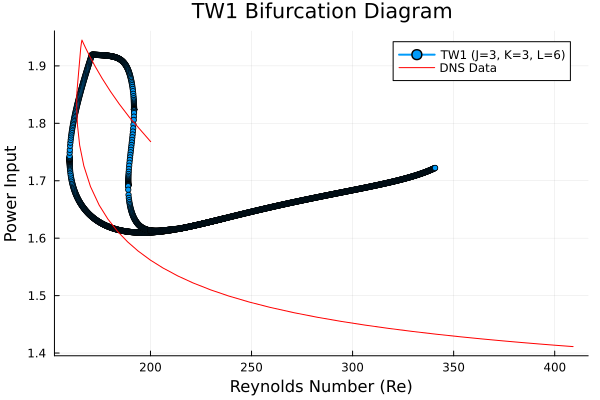

In [8]:
# Plot Re (branch.param) vs Power (branch.pow)
plot(branch.param, branch.pow,
    xlabel = "Reynolds Number (Re)",
    ylabel = "Power Input",
    title = "TW1 Bifurcation Diagram",
    linewidth = 2,
    marker = :circle,
    markersize = 3,
    legend = :topright,
    label = "TW1 (J=$(J), K=$(K), L=$(L))"
)

# Optional: Add DNS comparison
if isfile("data/tw1Re-DNS.asc")
    data, _ = readdlm("data/tw1Re-DNS.asc", header=true)
    plot!(data[:,1], data[:,2], 
        label = "DNS Data", 
        color = :red, 
        # markershape = :cross
    )
end